In [ ]:
!pip install spectral

In [ ]:
import numpy as np
import scipy.io as sio
import os
import time
import spectral

from sklearn import cluster, metrics
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from tensorflow import keras

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, Model

from dataclasses import dataclass
from einops import rearrange, repeat
from typing import Union



import math
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

HSI = sio.loadmat(os.path.join(os.getcwd(),'/content/drive/MyDrive/Colab Notebooks/IndianPines-20241017T061014Z-001/IndianPines/Indian_pines_corrected.mat'))['indian_pines_corrected']
GT = sio.loadmat(os.path.join(os.getcwd(),'/content/drive/MyDrive/Colab Notebooks/IndianPines-20241017T061014Z-001/IndianPines/Indian_pines_gt.mat'))['indian_pines_gt']


** VISUALIZE HSI AND GT**

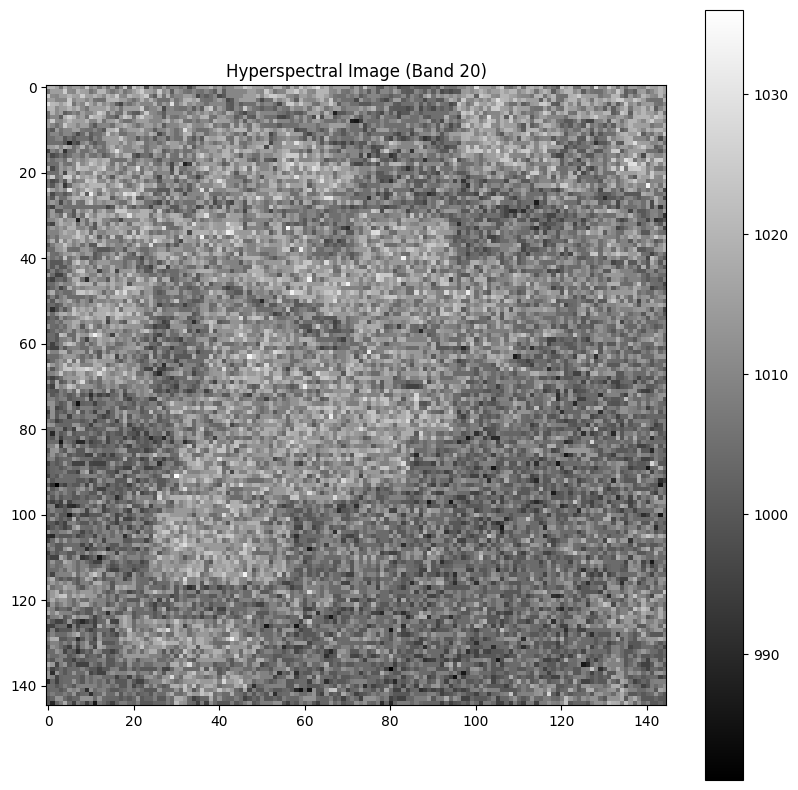

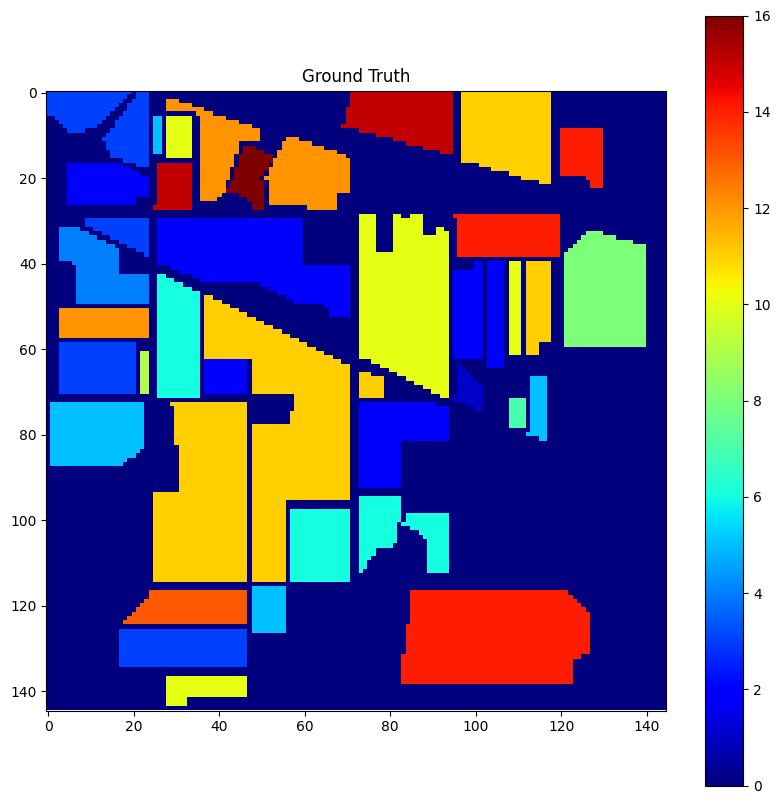

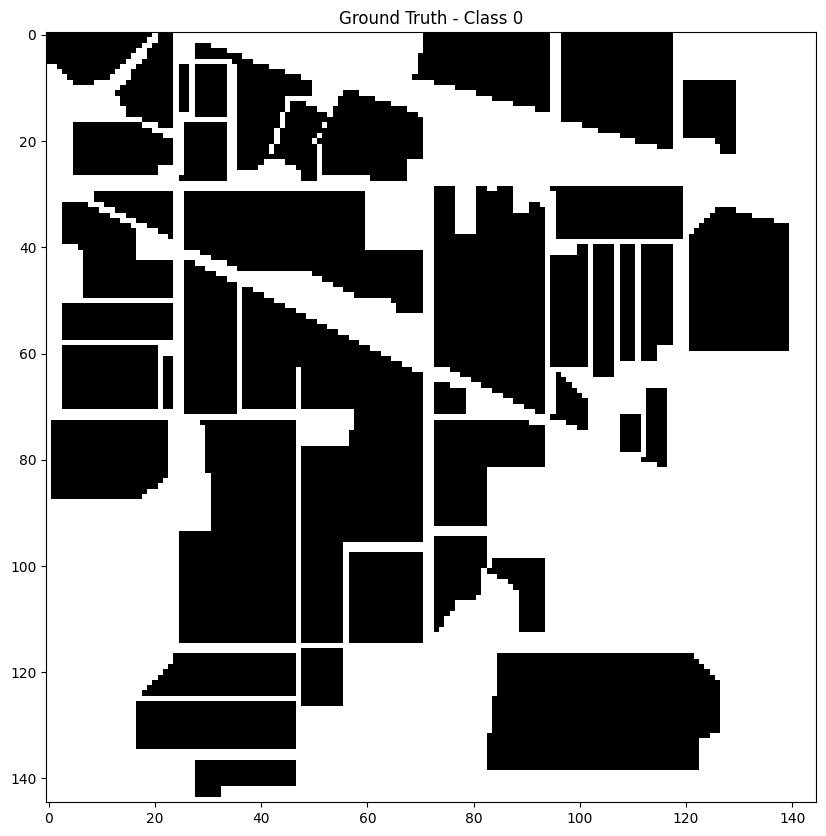

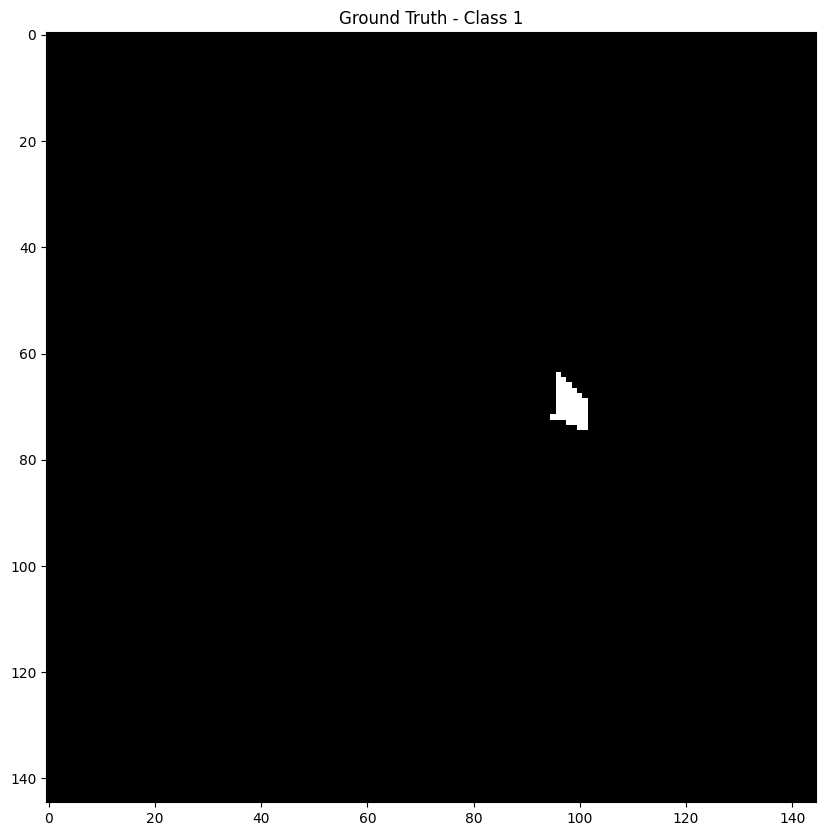

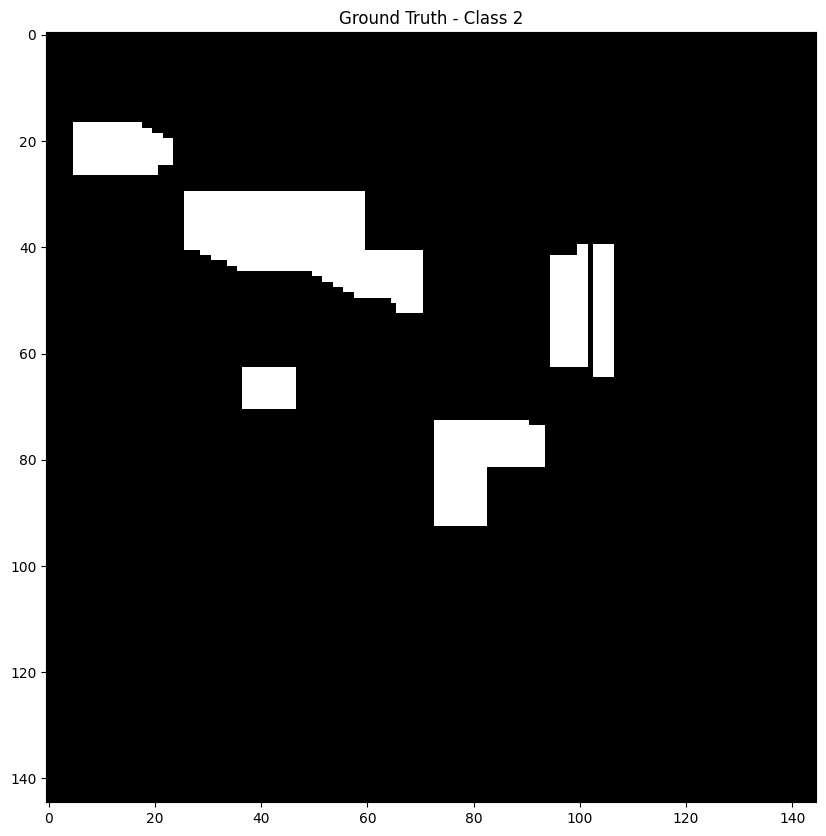

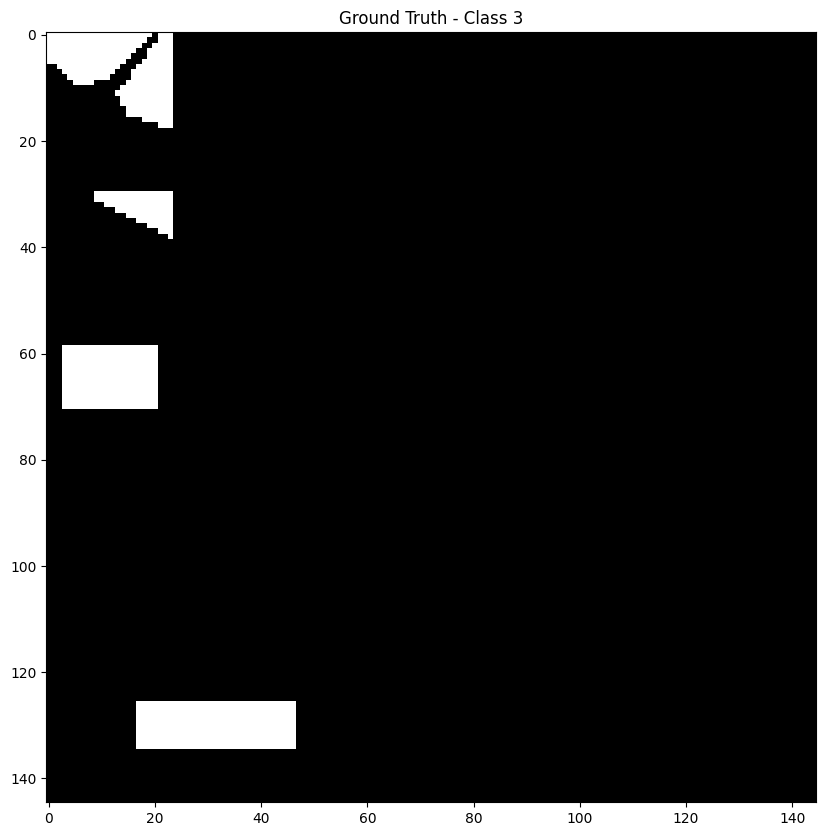

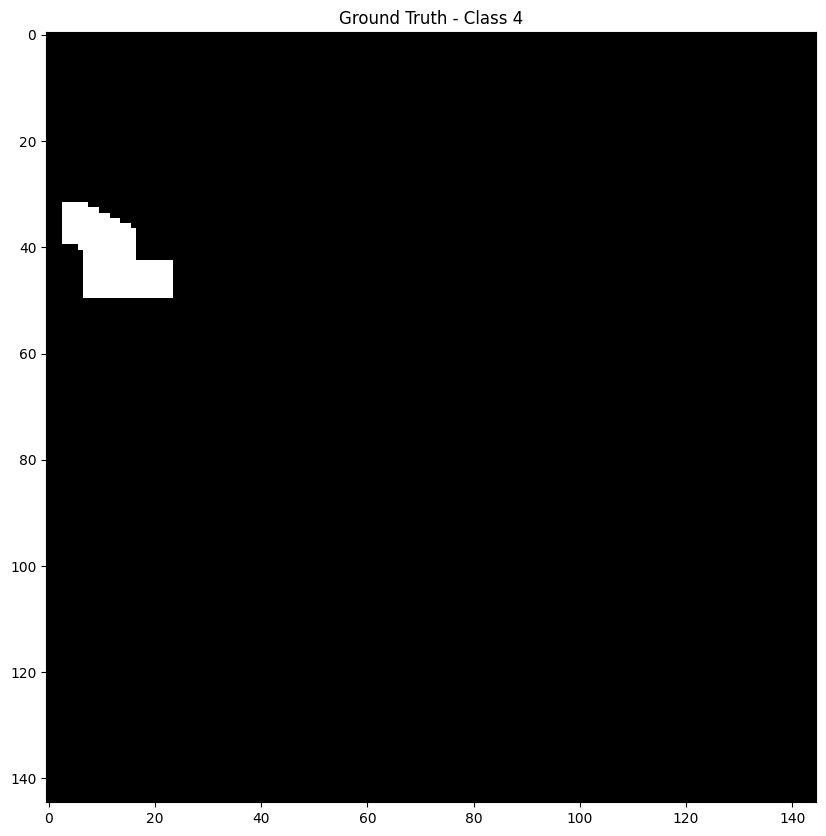

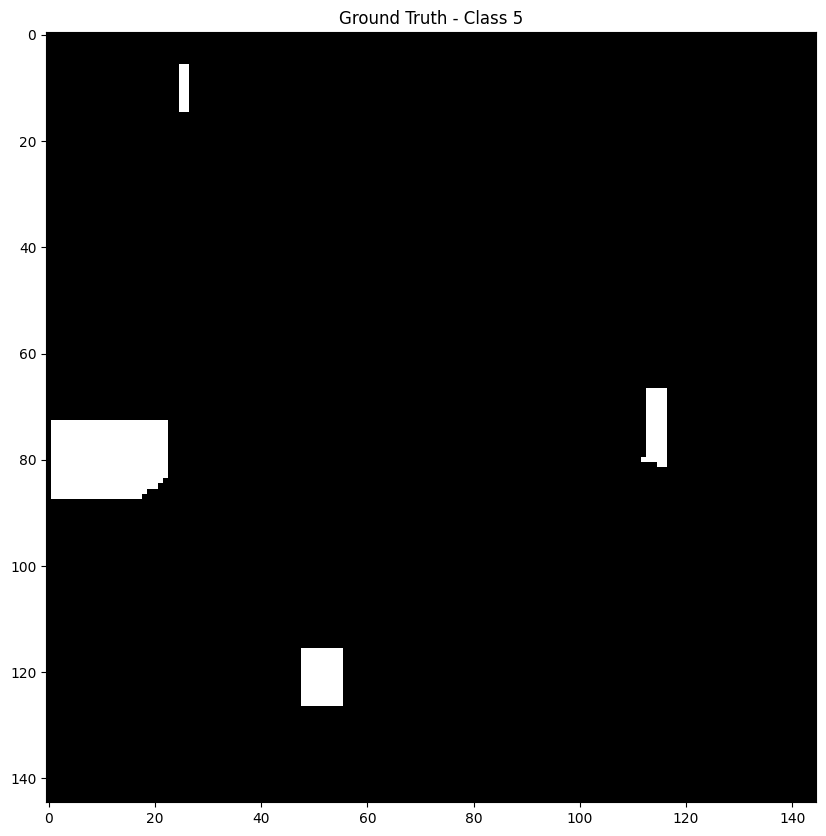

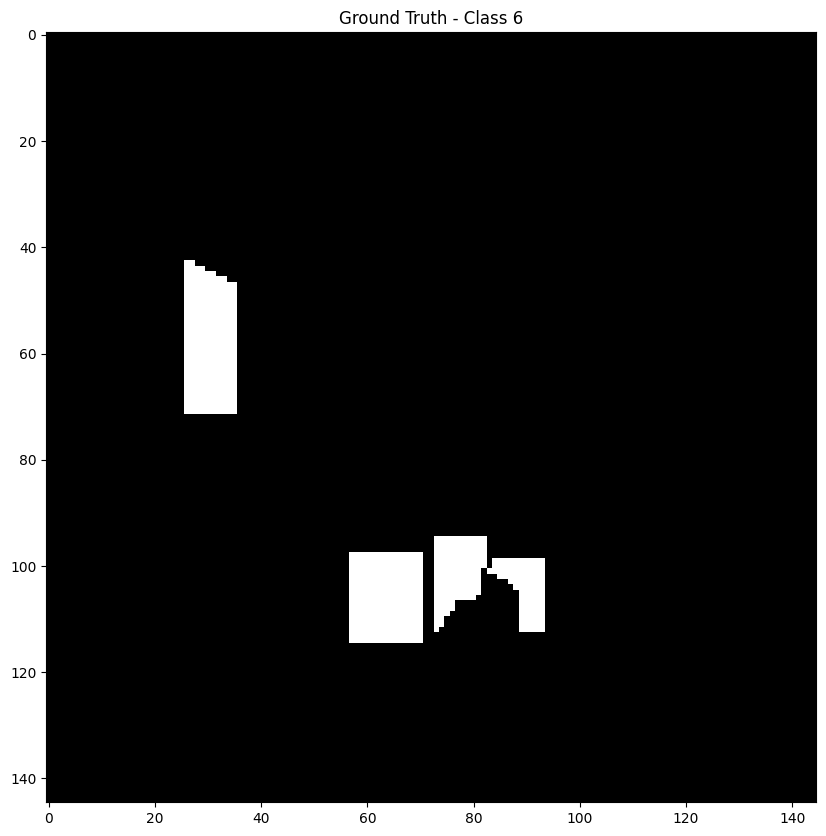

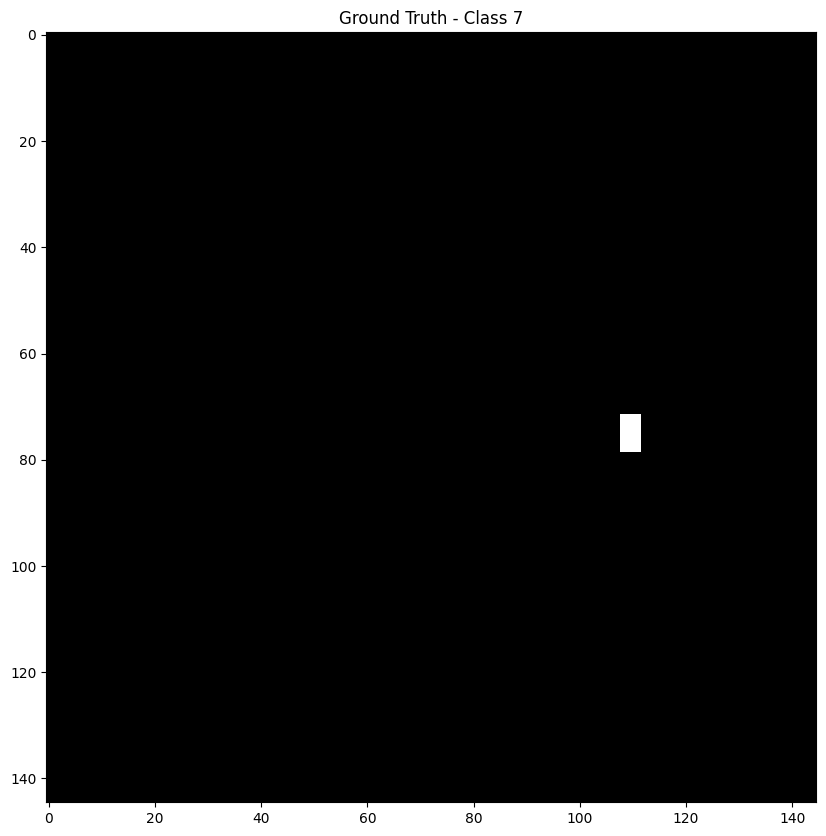

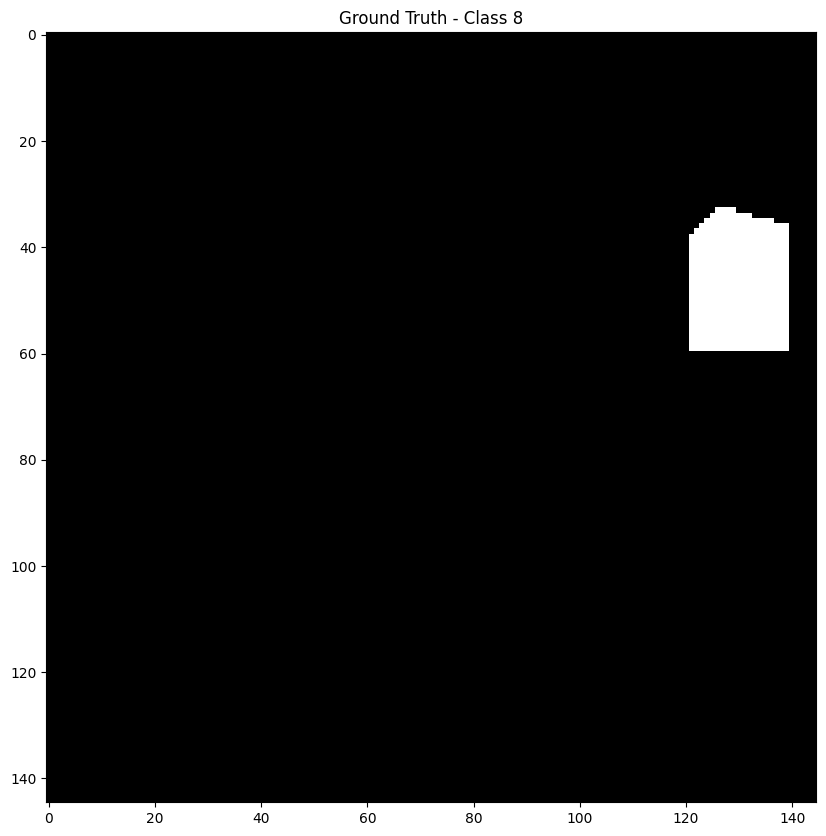

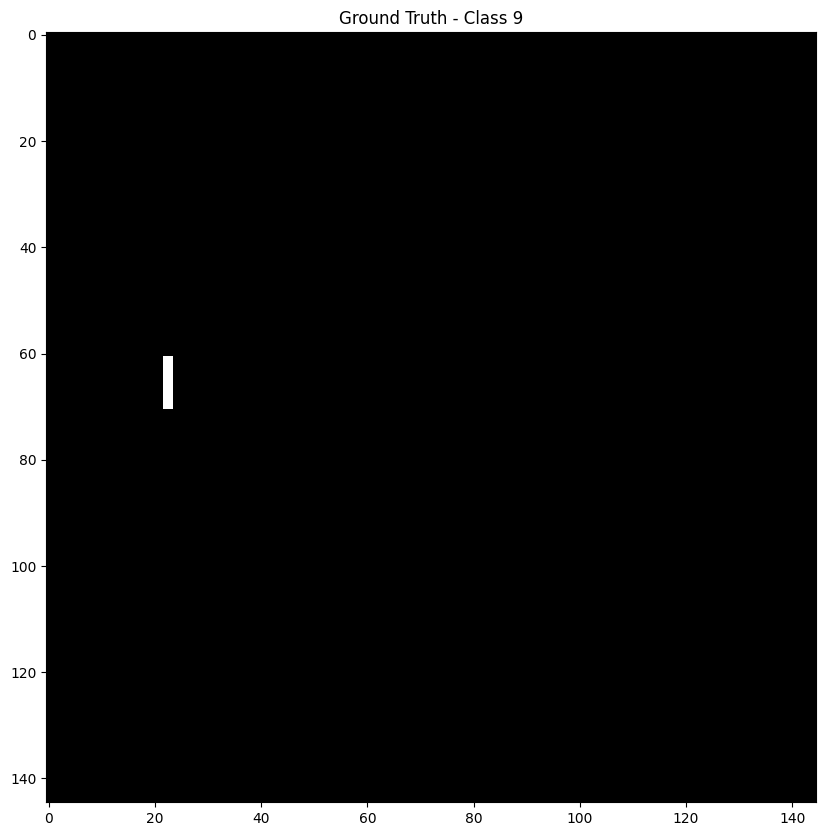

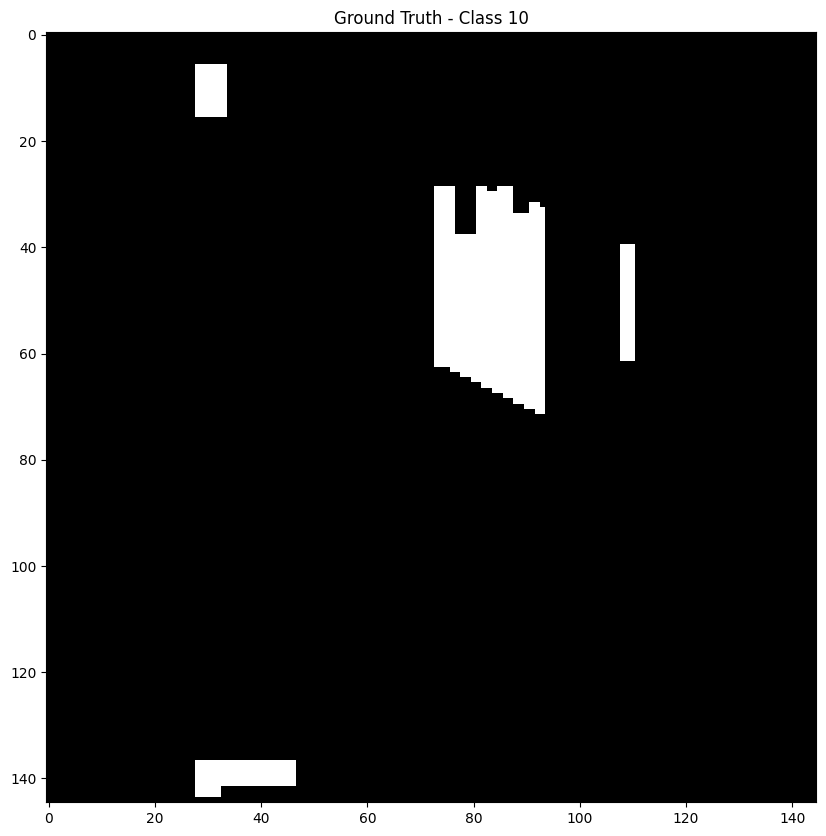

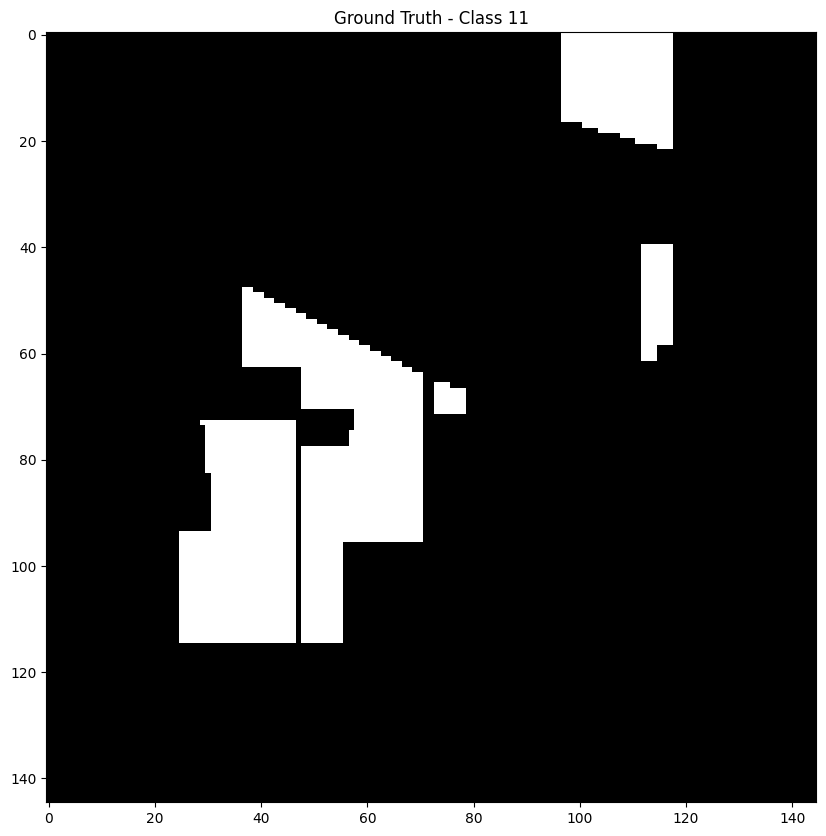

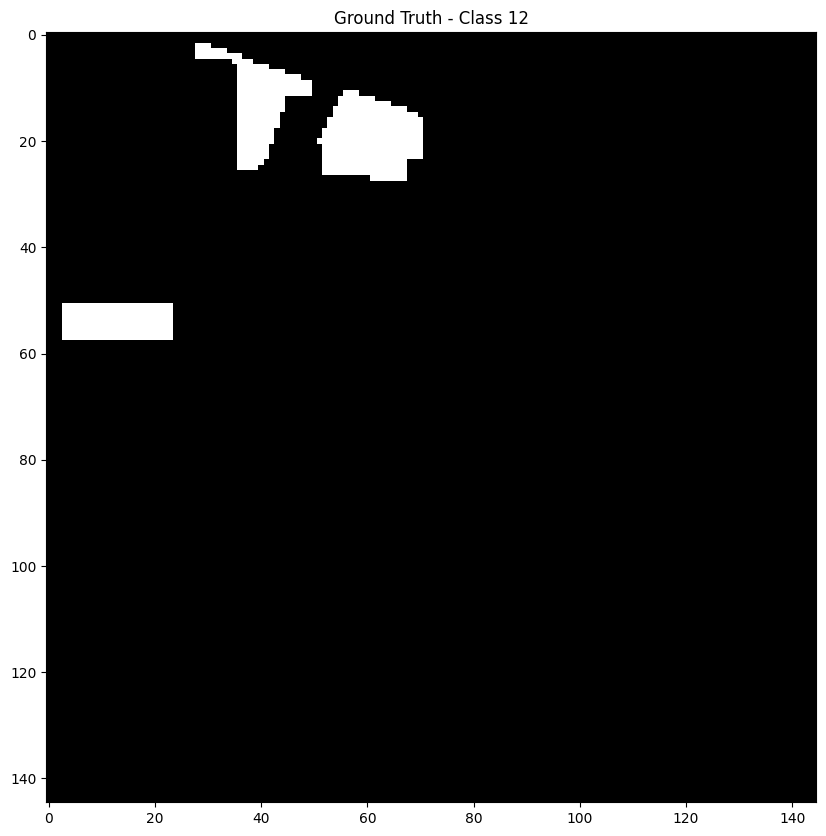

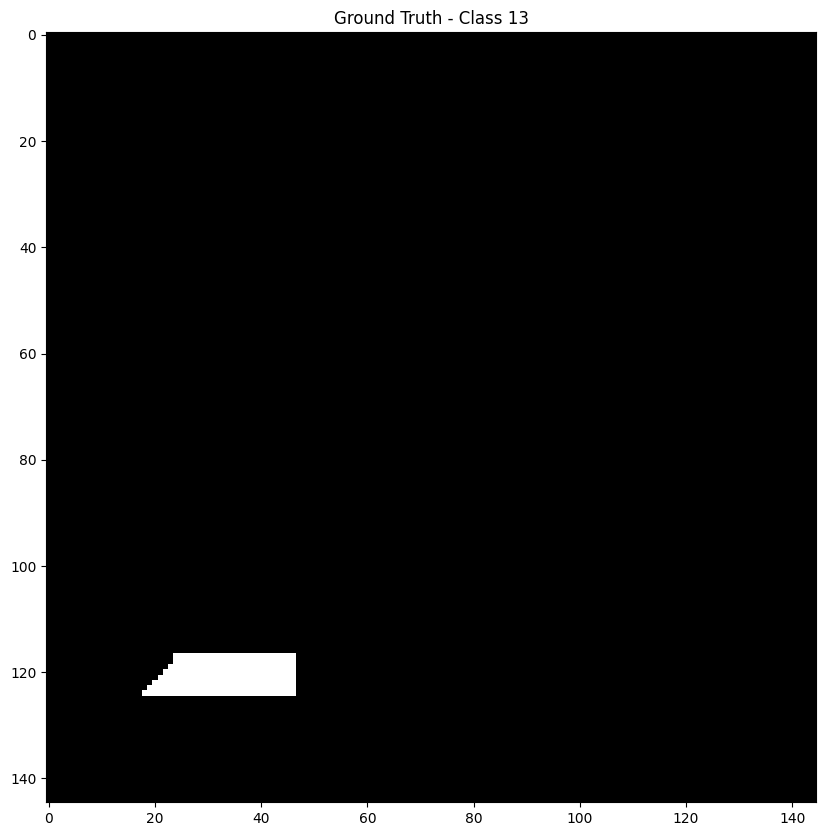

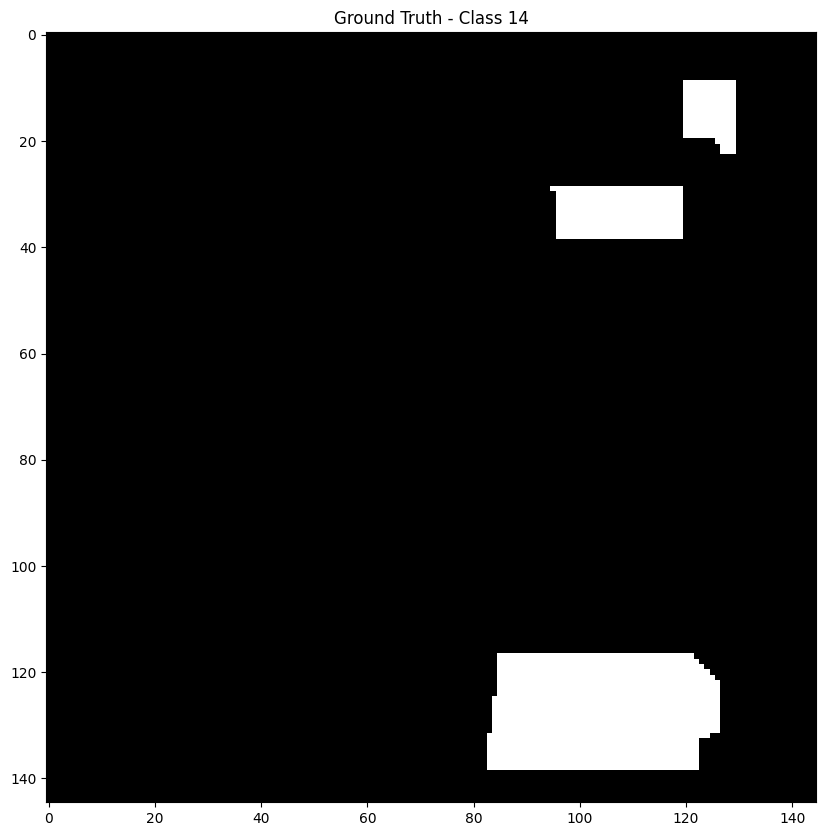

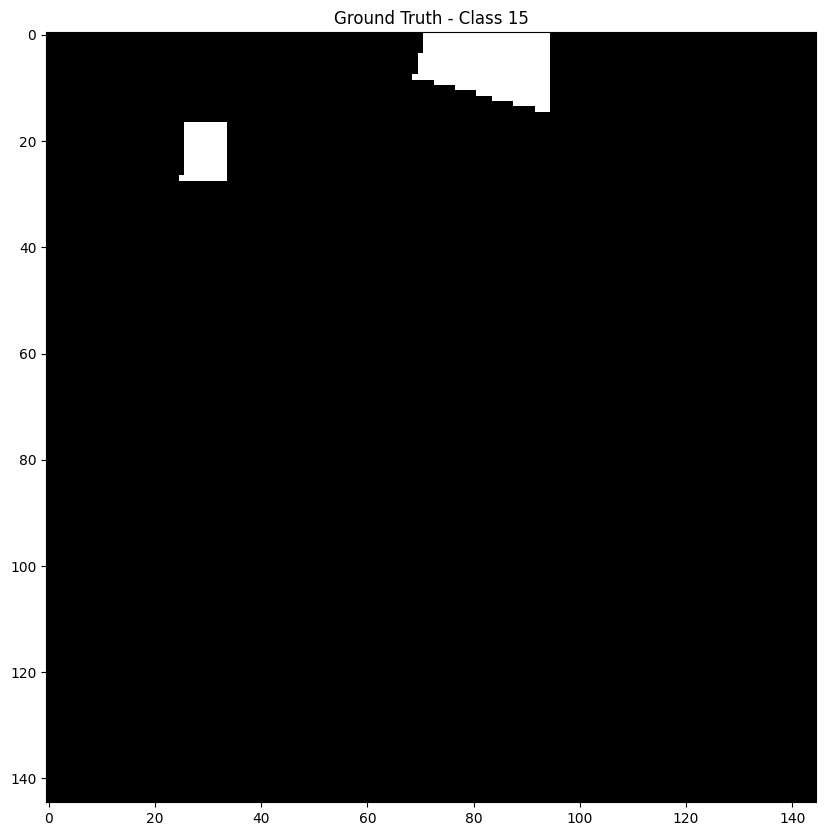

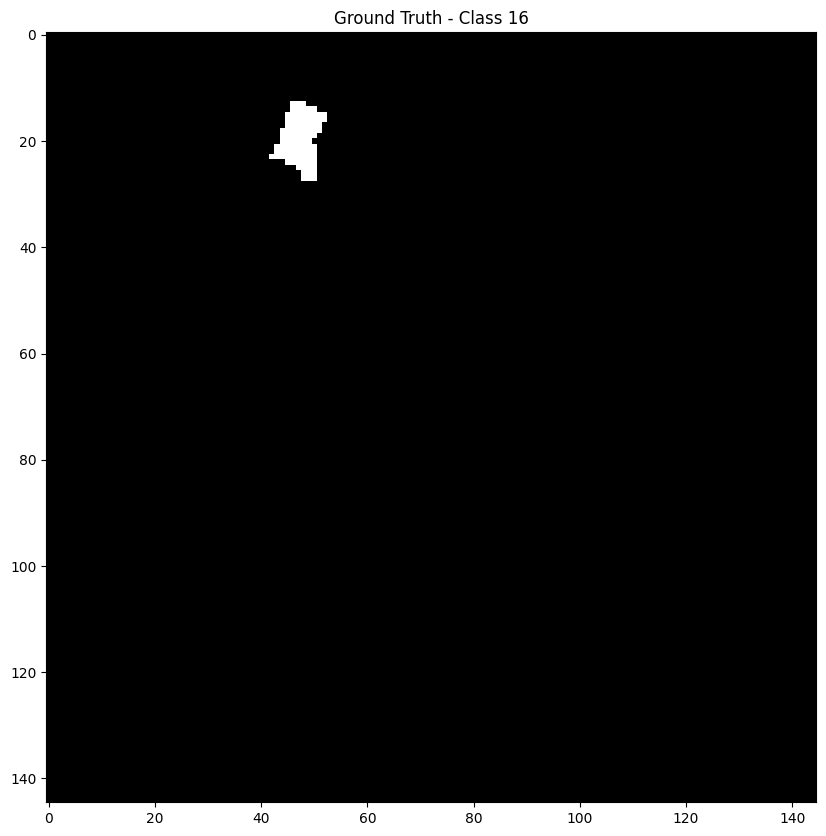

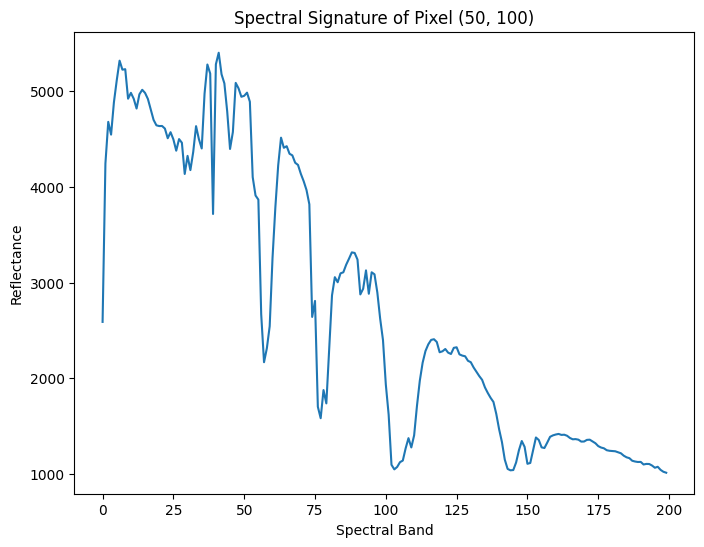

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming HSI and GT are already loaded as in your provided code

# Display the HSI image (you can choose specific bands for visualization)
plt.figure(figsize=(10, 10))
plt.imshow(HSI[:, :, 199], cmap='gray')  # Display band 20 as an example
plt.title('Hyperspectral Image (Band 20)')
plt.colorbar()
plt.show()

# Display the Ground Truth image
plt.figure(figsize=(10, 10))
plt.imshow(GT, cmap='jet') # Use a colormap suitable for categorical data
plt.title('Ground Truth')
plt.colorbar()
plt.show()

# Visualize each class in the ground truth using a for loop
unique_classes = np.unique(GT)  # Get the unique classes in GT

for target_class in unique_classes:
    class_mask = (GT == target_class)  # Create a mask for the current class
    plt.figure(figsize=(10,10))
    plt.imshow(class_mask, cmap='grey')  # Display the mask for the target class
    plt.title(f'Ground Truth - Class {target_class}')
    plt.show()

# Example: Visualize a spectral signature of a pixel

# Choose pixel coordinates (x, y)
x_coord = 50
y_coord = 100

# Plot the spectral signature for the selected pixel
plt.figure(figsize=(8, 6))
plt.plot(HSI[x_coord, y_coord, :])
plt.title(f'Spectral Signature of Pixel ({x_coord}, {y_coord})')
plt.xlabel('Spectral Band')
plt.ylabel('Reflectance')
plt.show()


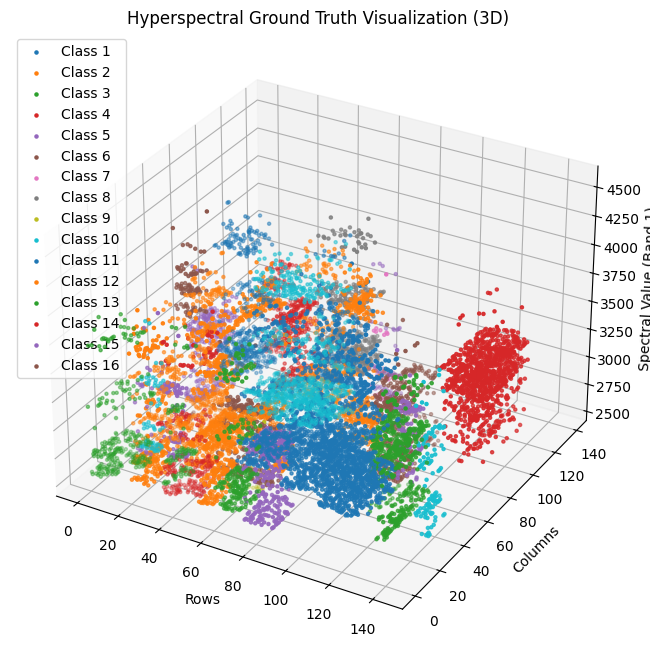

In [ ]:


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming HSI and GT are already loaded

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get unique classes
unique_classes = np.unique(GT)

# Iterate through each class
for class_label in unique_classes:
    if class_label == 0:  # Skip class 0 (background or no-data)
        continue

    # Find indices of pixels belonging to the current class
    rows, cols = np.where(GT == class_label)

    # Extract spectral data for the current class
    spectral_data = HSI[rows, cols, :]  # Adjust spectral band selection as needed

    # Plot the data points in 3D
    ax.scatter(rows, cols, spectral_data[:, 0], label=f"Class {class_label}", s=5) # Plot using first band

# Set plot labels and title
ax.set_xlabel("Rows")
ax.set_ylabel("Columns")
ax.set_zlabel("Spectral Value (Band 1)")
ax.set_title("Hyperspectral Ground Truth Visualization (3D)")
ax.legend()

# Show the plot
plt.show()

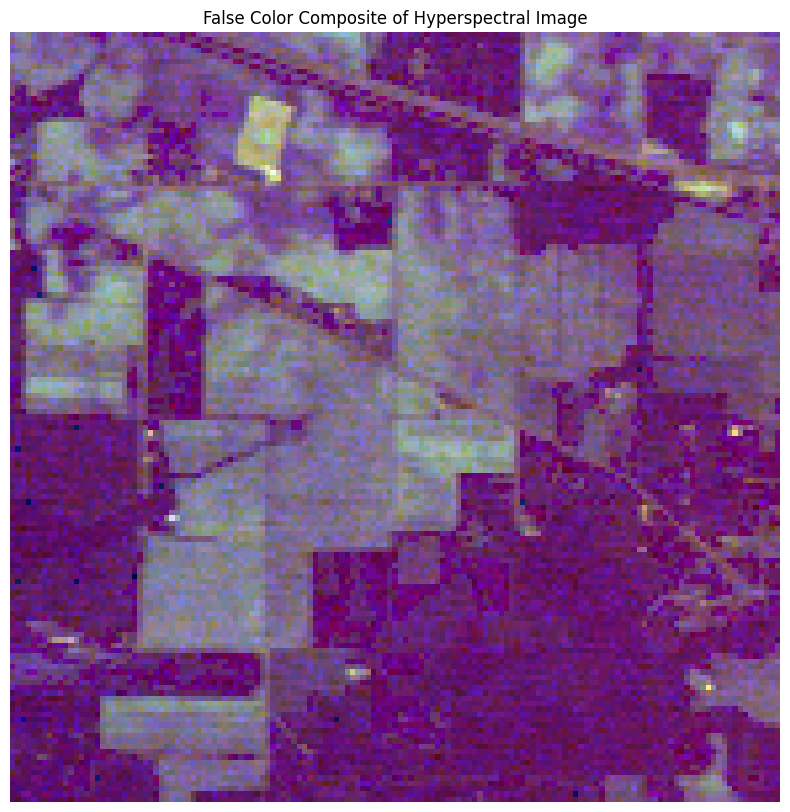

In [ ]:
# Get the shape of the hyperspectral image (height, width, num_bands)
height, width, num_bands = HSI.shape

# Select three bands corresponding to RGB (commonly bands 30, 20, and 10 in Indian Pines dataset)
# Here, we use band 30 for Red, band 20 for Green, and band 10 for Blue
band_red = 1 # Near-infrared or red-band equivalent (you can choose a band in the visible range)
band_green = 20  # Green band
band_blue = 199  # Blue band

# Extract the bands and normalize them to fit the 0-255 range
red = HSI[:, :, band_red]
green = HSI[:, :, band_green]
blue = HSI[:, :, band_blue]

# Normalize each band to the range 0-255
red = np.clip((red - red.min()) / (red.max() - red.min()) * 255, 0, 255).astype(np.uint8)
green = np.clip((green - green.min()) / (green.max() - green.min()) * 255, 0, 255).astype(np.uint8)
blue = np.clip((blue - blue.min()) / (blue.max() - blue.min()) * 255, 0, 255).astype(np.uint8)

# Combine the three bands into an RGB image
RGB_image = np.stack((red, green, blue), axis=-1)

# Display the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(RGB_image)
plt.title('False Color Composite of Hyperspectral Image')
plt.axis('off')
plt.show()


**PCA**

In [ ]:
test_ratio = 0.9
patch = 25
PCsNum = 15
ClusterNum = 100

In [ ]:
HPCs = PCA(n_components=PCsNum, whiten=True).fit_transform(HSI.reshape(-1, HSI.shape[2])).reshape(HSI.shape[0], HSI.shape[1], PCsNum)

In [ ]:


print(f"Shape of HPCs: {HPCs.shape}")

Shape of HPCs: (145, 145, 15)


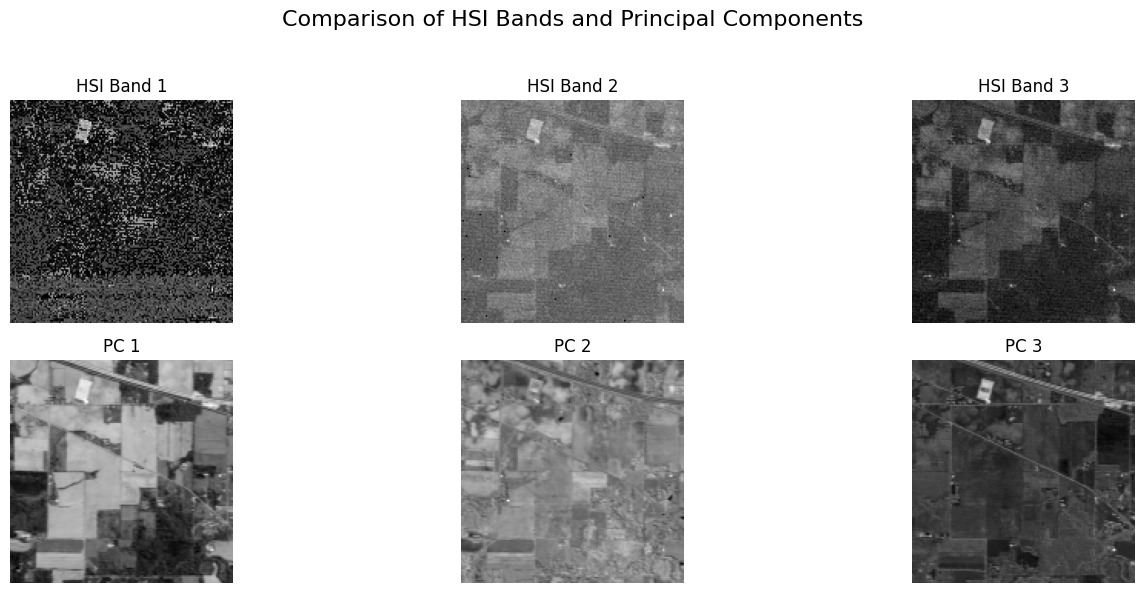

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize HSI and HPCs
def visualize_hsi_and_hpcs(HSI, HPCs, bands_to_show=3):
    """
    Visualize bands of the original HSI and HPCs side by side for comparison.

    Parameters:
        HSI: np.ndarray
            Original hyperspectral image (3D array: height x width x num_bands).
        HPCs: np.ndarray
            Transformed image with principal components (3D array: height x width x PCsNum).
        bands_to_show: int
            Number of bands or components to display (default: 3).
    """
    # Ensure the number of bands/components to show is valid
    bands_to_show = min(bands_to_show, HSI.shape[2], HPCs.shape[2])

    # Normalize for visualization
    def normalize_image(image):
        return (image - np.min(image)) / (np.max(image) - np.min(image))

    # Normalize both HSI and HPCs for fair comparison
    HSI_norm = normalize_image(HSI)
    HPCs_norm = normalize_image(HPCs)

    # Set up the figure
    fig, axes = plt.subplots(2, bands_to_show, figsize=(15, 6))
    fig.suptitle("Comparison of HSI Bands and Principal Components", fontsize=16)

    for i in range(bands_to_show):
        # Display HSI band
        axes[0, i].imshow(HSI_norm[:, :, i], cmap='gray')
        axes[0, i].set_title(f"HSI Band {i+1}")
        axes[0, i].axis('off')

        # Display corresponding HPC component
        axes[1, i].imshow(HPCs_norm[:, :, i], cmap='gray')
        axes[1, i].set_title(f"PC {i+1}")
        axes[1, i].axis('off')

    # Add labels for rows
    axes[0, 0].set_ylabel("Original HSI", fontsize=12)
    axes[1, 0].set_ylabel("HPCs", fontsize=12)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example Usage:
# HSI and HPCs should be 3D arrays: (height, width, num_bands/PCsNum)
visualize_hsi_and_hpcs(HSI, HPCs, bands_to_show=3)


In [ ]:


# Number of bands in HSI
num_hsi_bands = HSI.shape[2]
print(f"Number of bands in HSI: {num_hsi_bands}")

# Number of principal components (bands) in HPCs
num_hpc_bands = HPCs.shape[2]
print(f"Number of bands in HPCs: {num_hpc_bands}")

Number of bands in HSI: 200
Number of bands in HPCs: 15


##**CLUSTERING**

In [ ]:
start_time = time.process_time()
clusterstack = np.zeros(HPCs.shape)

mbk_means = cluster.MiniBatchKMeans(n_clusters=ClusterNum).fit(HPCs.reshape((-1, HPCs.shape[2])))
clusterlabel = mbk_means.labels_.reshape((GT.shape))

for i in range(ClusterNum):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)

timeused = (time.process_time() - start_time)
print('Shape of Clusters:', clusterstack.shape, 'Clustering Time: ', timeused, 's.  # of Clusters:', np.max(clusterlabel)+1)

Shape of Clusters: (145, 145, 15) Clustering Time:  0.4075083500000005 s.  # of Clusters: 100


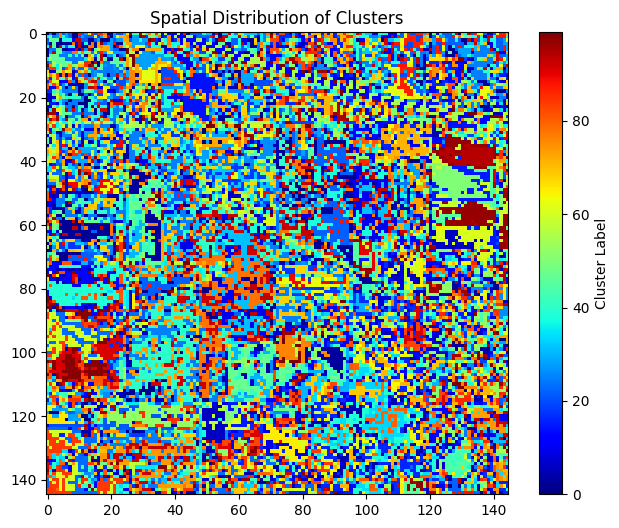

In [ ]:


import matplotlib.pyplot as plt


# Choose a cluster to visualize (e.g., cluster 0)
cluster_index = 0

# Extract the spectral signature of the chosen cluster
cluster_signature = clusterstack[clusterlabel == cluster_index][0]

'''
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(cluster_signature)
plt.xlabel("Spectral Band")
plt.ylabel("Reflectance")
plt.title(f"Spectral Signature of Cluster {cluster_index}")
plt.grid(True)
plt.show()
'''

# Visualize the spatial distribution of the clusters
plt.figure(figsize=(8, 6))
plt.imshow(clusterlabel, cmap='jet')  # Use a colormap suitable for cluster visualization
plt.colorbar(label="Cluster Label")
plt.title("Spatial Distribution of Clusters")
plt.show()

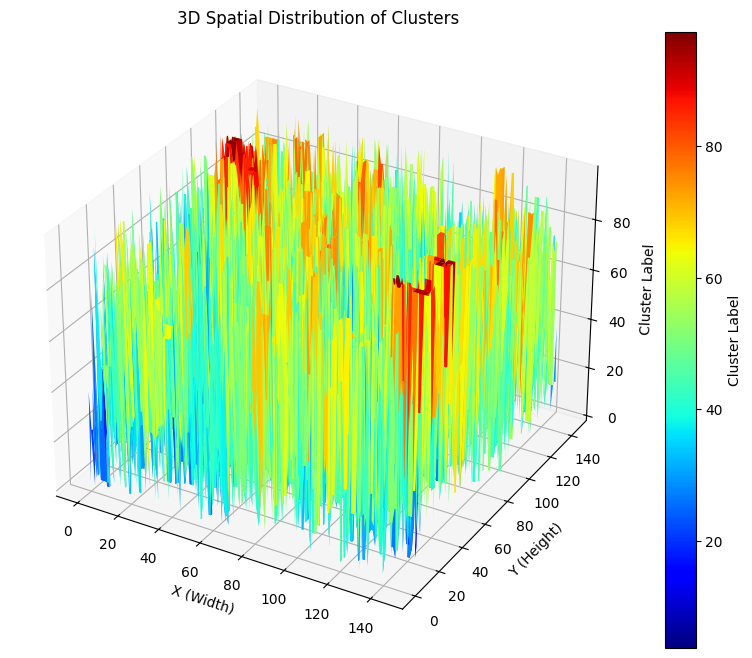

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

# Generate x and y grid corresponding to the spatial dimensions
x = np.arange(clusterlabel.shape[1])  # Width
y = np.arange(clusterlabel.shape[0])  # Height
x, y = np.meshgrid(x, y)

# Use clusterlabel as the z-axis values
z = clusterlabel

# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(x, y, z, cmap='jet', edgecolor='none')

# Add color bar
fig.colorbar(surface, ax=ax, label="Cluster Label")

# Add labels and title
ax.set_xlabel("X (Width)")
ax.set_ylabel("Y (Height)")
ax.set_zlabel("Cluster Label")
ax.set_title("3D Spatial Distribution of Clusters")

# Show the plot
plt.show()


In [ ]:
class ModelArgs:
    model_input_dims: int = 64
    model_states: int = 64
    projection_expand_factor: int = 2
    conv_kernel_size: int = 4
    delta_t_min: float = 0.001
    delta_t_max: float = 0.1
    delta_t_scale: float = 0.1
    delta_t_init_floor: float = 1e-4
    conv_use_bias: bool = True
    dense_use_bias: bool = False
    layer_id: int = -1
    seq_length: int = 128
    num_layers: int = 5
    dropout_rate: float = 0.2
    use_lm_head: float = False
    num_classes: int = None
    vocab_size: int = None
    final_activation = None
    loss:Union[str, keras.losses.Loss] = None
    optimizer: Union[str, keras.optimizers.Optimizer] = keras.optimizers.AdamW()
    metrics = ['accuracy']

    def __post_init__(self):
        self.model_internal_dim: int = int(self.projection_expand_factor * self.model_input_dims)

        self.delta_t_rank = math.ceil(self.model_input_dims/16)
        if self.layer_id == -1:
            self.layer_id = np.round(np.random.randint(0, 1000), 4)

        if self.vocab_size == None:
            raise ValueError("vocab size cannot be none")

        if self.use_lm_head:
            self.num_classes=self.vocab_size
        else:
            if self.num_classes == None:
                raise ValueError(f'num classes cannot be {self.num_classes}')

            if self.num_classes == 1:
                self.final_activation = 'sigmoid'
            else:
                self.final_activation = 'softmax'

        if self.loss == None:
            raise ValueError(f"loss cannot be {self.loss}")

In [ ]:
# Assuming ModelArgs is defined somewhere with appropriate attributes
class ModelArgs:
    def __init__(self, model_input_dims, model_internal_dim, conv_kernel_size, delta_t_rank, model_states, conv_use_bias=True, dense_use_bias=True, layer_id=None):
        self.model_input_dims = model_input_dims
        self.model_internal_dim = model_internal_dim
        self.conv_kernel_size = conv_kernel_size
        self.delta_t_rank = delta_t_rank
        self.model_states = model_states
        self.conv_use_bias = conv_use_bias
        self.dense_use_bias = dense_use_bias
        self.layer_id = layer_id

# Define the model arguments
args = ModelArgs(
    model_input_dims=PCsNum,  # Number of PCA components
    model_internal_dim=64,     # Example internal dimension
    conv_kernel_size=3,        # Example kernel size
    delta_t_rank=1,            # Example delta rank
    model_states=2,              # Example number of states
    layer_id=0
)




##MAMBA MODEL

In [ ]:
def selective_scan(u, delta, A, B, C, D):
    # first step of A_bar = exp(ΔA), i.e., ΔA
    dA = tf.einsum('bld,dn->bldn', delta, A)
    dB_u = tf.einsum('bld,bld,bln->bldn', delta, u, B)

    dA_cumsum = tf.pad(
        dA[:, 1:], [[0, 0], [1, 1], [0, 0], [0, 0]])[:, 1:, :, :]

    dA_cumsum = tf.reverse(dA_cumsum, axis=[1])  # Flip along axis 1

    # Cumulative sum along all the input tokens, parallel prefix sum,
    # calculates dA for all the input tokens parallely
    dA_cumsum = tf.math.cumsum(dA_cumsum, axis=1)

    # second step of A_bar = exp(ΔA), i.e., exp(ΔA)
    dA_cumsum = tf.exp(dA_cumsum)
    dA_cumsum = tf.reverse(dA_cumsum, axis=[1])  # Flip back along axis 1

    x = dB_u * dA_cumsum
    # 1e-12 to avoid division by 0
    x = tf.math.cumsum(x, axis=1)/(dA_cumsum + 1e-12)

    y = tf.einsum('bldn,bln->bld', x, C)

    return y + u * D

In [ ]:
class MambaBlock(layers.Layer):
    def __init__(self, modelargs: ModelArgs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.args = modelargs
        args = modelargs
        self.layer_id = modelargs.layer_id

        self.in_projection = layers.Dense(
            args.model_internal_dim * 2,
            input_shape=(args.model_input_dims,), use_bias=False)

        self.conv1d = layers.Conv1D(
            filters=args.model_internal_dim,
            use_bias=args.conv_use_bias,
            kernel_size=args.conv_kernel_size,
            groups=args.model_internal_dim,
            data_format='channels_first',
            padding='causal'
        )

        # this layer takes in current token 'x'
        # and outputs the input-specific Δ, B, C (according to S6)
        self.x_projection = layers.Dense(args.delta_t_rank + args.model_states * 2, use_bias=False)

        # this layer projects Δ from delta_t_rank to the mamba internal
        # dimension
        self.delta_t_projection = layers.Dense(args.model_internal_dim,
                                               input_shape=(args.delta_t_rank,), use_bias=True)

        self.A = repeat(
                tf.range(1, args.model_states+1, dtype=tf.float32),
                'n -> d n', d=args.model_internal_dim)

        self.A_log = tf.Variable(
                tf.math.log(self.A),
                trainable=True, dtype=tf.float32,
                name=f"SSM_A_log_{args.layer_id}")

        self.D = tf.Variable(
                np.ones(args.model_internal_dim),
                trainable=True, dtype=tf.float32,
                name=f"SSM_D_{args.layer_id}")

        self.out_projection = layers.Dense(
                args.model_input_dims,
                input_shape=(args.model_internal_dim,),
                use_bias=args.dense_use_bias)

    def call(self, x):
        """Mamba block forward. This looks the same as Figure 3 in Section 3.4 in the Mamba pape.
        Official Implementation:
            class Mamba, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L119
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311
        """
        (batch_size, seq_len, dimension) = x.shape

        x_and_res = self.in_projection(x) # shape = (batch, seq_len, 2 * model_internal_dimension)
        (x, res) = tf.split(x_and_res,
                            [self.args.model_internal_dim,
                             self.args.model_internal_dim], axis=-1)

        x = rearrange(x, 'b l d_in -> b d_in l')
        x = self.conv1d(x)[:, :, :seq_len]
        x = rearrange(x, 'b d_in l -> b l d_in')

        x = tf.nn.swish(x)
        y = self.ssm(x)
        y = y * tf.nn.swish(res)
        return self.out_projection(y)

    def ssm(self, x):
        """Runs the SSM. See:
            - Algorithm 2 in Section 3.2 in the Mamba paper
            - run_SSM(A, B, C, u) in The Annotated S4
            Official Implementation:
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311
        """
        (d_in, n) = self.A_log.shape

        # Compute ∆ A B C D, the state space parameters.
        #     A, D are input independent (see Mamba paper [1] Section 3.5.2 "Interpretation of A" for why A isn't selective)
        #     ∆, B, C are input-dependent (this is a key difference between Mamba and the linear time invariant S4,
        #                                  and is why Mamba is called **selective** state spaces)

        A = -tf.exp(tf.cast(self.A_log, tf.float32)) # shape -> (d_in, n)
        D = tf.cast(self.D, tf.float32)

        x_dbl = self.x_projection(x) # shape -> (batch, seq_len, delta_t_rank + 2*n)

        (delta, B, C) = tf.split(
                x_dbl,
                num_or_size_splits=[self.args.delta_t_rank, n, n],
                axis=-1) # delta.shape -> (batch, seq_len) & B, C shape -> (batch, seq_len, n)

        delta = tf.nn.softplus(self.delta_t_projection(delta)) # shape -> (batch, seq_len, model_input_dim)

        return selective_scan(x, delta, A, B, C, D)

In [ ]:
class ResidualBlock(layers.Layer):
    def __init__(self, modelargs: ModelArgs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.args = modelargs
        self.mixer = MambaBlock(modelargs)
        self.norm = layers.LayerNormalization(epsilon=1e-5)

    def call(self, x):
        """
        Official Implementation:
            Block.forward(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L297

            Note: the official repo chains residual blocks that look like
                [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> ...
            where the first Add is a no-op. This is purely for performance reasons as this
            allows them to fuse the Add->Norm.

            We instead implement our blocks as the more familiar, simpler, and numerically equivalent
                [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> ....

        """
        return self.mixer(self.norm(x)) + x

In [ ]:

# clusterstack.shape is (height, width, PCsNum)
# We need to convert it to (batch_size, seq_len, dimension)

# Reshape the clusterstack
height, width, _ = clusterstack.shape
seq_len = height * width  # Total number of pixels
dimension = PCsNum         # Number of PCA components

# Reshape to (batch_size, seq_len, dimension)
#formatted_input = clusterstack.reshape((seq_len, dimension))  # (seq_len, dimension)

# If the MambaBlock expects a batch dimension, we can add it
# For example, we can treat the entire reshaped data as a single batch
#formatted_input = np.expand_dims(formatted_input, axis=0)  # (1, seq_len, dimension)

In [ ]:

def createImageCubes(X, y, windowSize=5, removeZeroLabels=True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2]))
    zeroPaddedX[margin:X.shape[0] + margin, margin:X.shape[1] + margin, :] = X

    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize,windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchesIndices = []  # Store indices

    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patchesData[patchIndex, :, :, :] = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesLabels[patchIndex] = y[r - margin, c - margin]
            patchesIndices.append((r - margin, c - margin))  # Track the original position in `y`
            patchIndex += 1

    patchesIndices = np.array(patchesIndices)  # Convert to numpy array for indexing

    if removeZeroLabels:
        non_zero_indices = patchesLabels > 0
        patchesData = patchesData[non_zero_indices, :, :, :]
        patchesLabels = patchesLabels[non_zero_indices] - 1
        patchesIndices = patchesIndices[non_zero_indices]  # Filter indices to keep only non-zero labels

    return patchesData, patchesLabels, patchesIndices


In [ ]:

# Modify `createImageCubes` to return indices
X, y, indices = createImageCubes(clusterstack, GT, windowSize=patch)

# Split the data, labels, and indices
Xtrain, Xtest, ytrain, ytest, train_indices, test_indices = train_test_split(X, y, indices, test_size=test_ratio, random_state=345, stratify=y)
# One-hot encoding of labels
ytrain1 = keras.utils.to_categorical(ytrain)
ytest1 = keras.utils.to_categorical(ytest)

In [ ]:
print("Patches Data Shape:", X.shape)  # (10000, 5, 5, 50)
print("Labels Shape:", y.shape)        # (10000,)
print("Indices Shape:", indices.shape)

Patches Data Shape: (10249, 25, 25, 15)
Labels Shape: (10249,)
Indices Shape: (10249, 2)


In [ ]:
# prompt: write code to show unique label of y

print(np.unique(y))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


In [ ]:


# Reshape the training and testing data for MambaBlock
# Xtrain.shape is (num_samples, patch, patch, PCsNum)
# We need to reshape it to (num_samples, seq_len, dimension)

num_samples = Xtrain.shape[0]
seq_len = patch * patch  # Total number of pixels in each patch
dimension = PCsNum       # Number of PCA components

# Reshape to (num_samples, seq_len, dimension)
Xtrain_mamba = Xtrain.reshape((num_samples, seq_len, dimension))
Xtest_mamba = Xtest.reshape((Xtest.shape[0], seq_len, dimension))

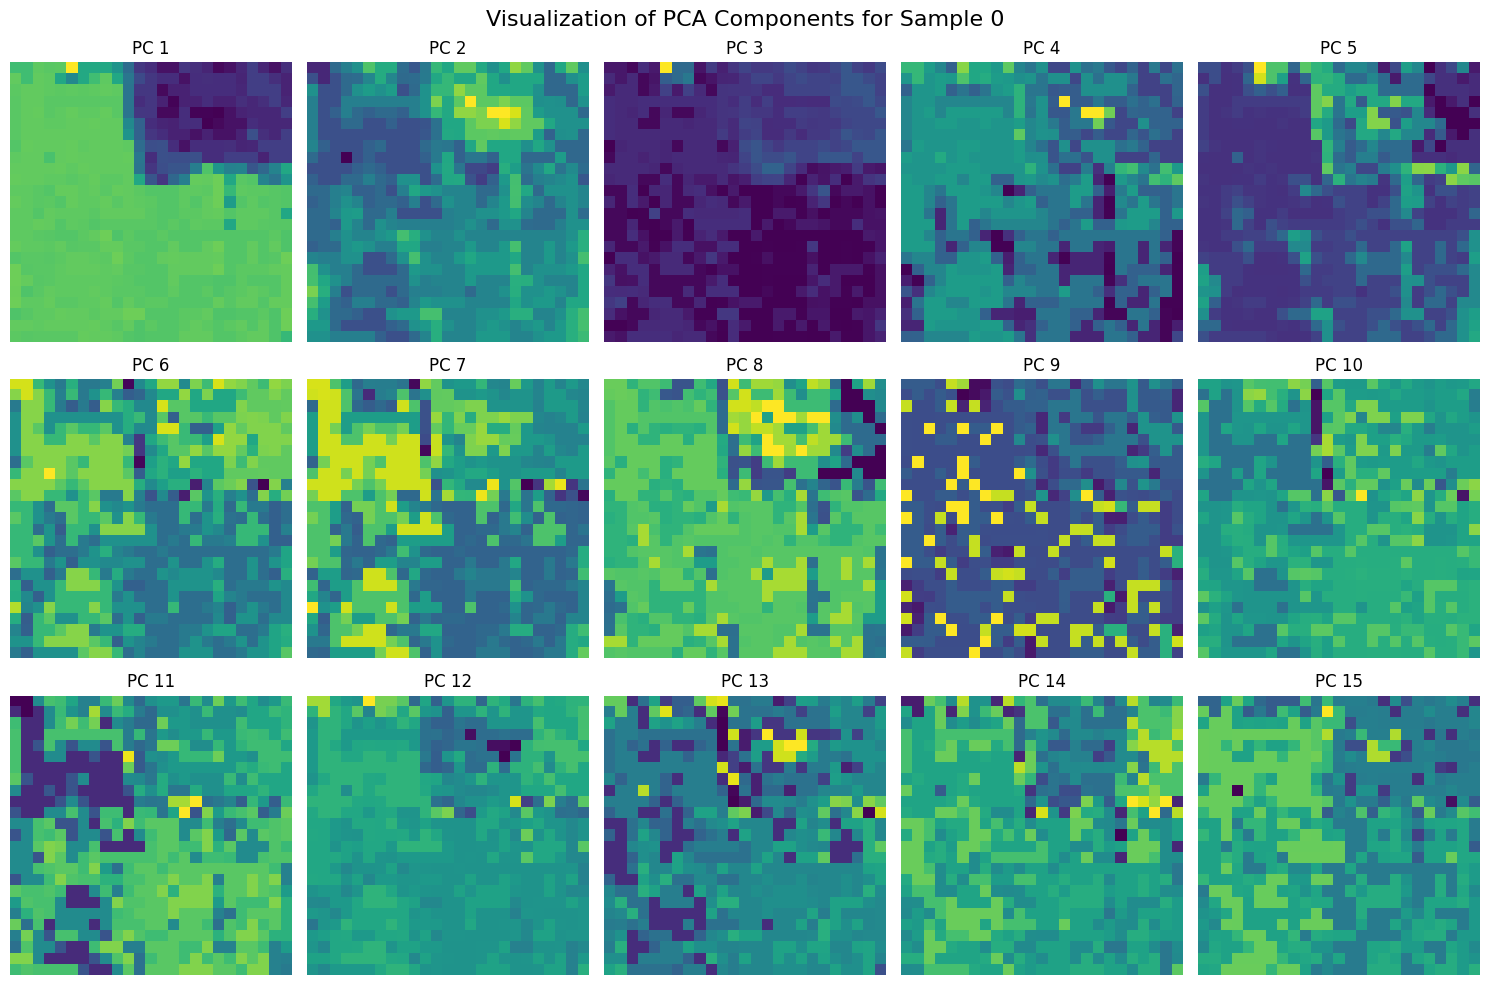

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_single_patch(Xtrain_mamba, sample_index=0):
    """
    Visualize a single patch from Xtrain_mamba as a 2D heatmap showing all 15 PCA components.

    Parameters:
        Xtrain_mamba: np.ndarray
            The reshaped training data (num_samples, seq_len, dimension).
        sample_index: int
            The index of the sample (patch) to visualize (default is 0).
    """
    # Select a patch (sample) from Xtrain_mamba
    sample_patch = Xtrain_mamba[sample_index]

    # Create a figure with subplots for each of the 15 PCA components
    fig, axes = plt.subplots(3, 5, figsize=(15, 10))

    for i in range(15):
        ax = axes[i // 5, i % 5]  # Get the correct subplot (3x5 grid)
        # The following line was changed to fix the IndexError
        # It now accesses the data for the i-th PCA component correctly
        ax.imshow(sample_patch[:, i].reshape(patch.shape[0], patch.shape[1]), cmap='viridis', aspect='auto')
        ax.set_title(f'PC {i+1}')
        ax.axis('off')  # Hide axes for clarity

    plt.suptitle(f"Visualization of PCA Components for Sample {sample_index}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_single_patch(Xtrain_mamba, sample_index=0)


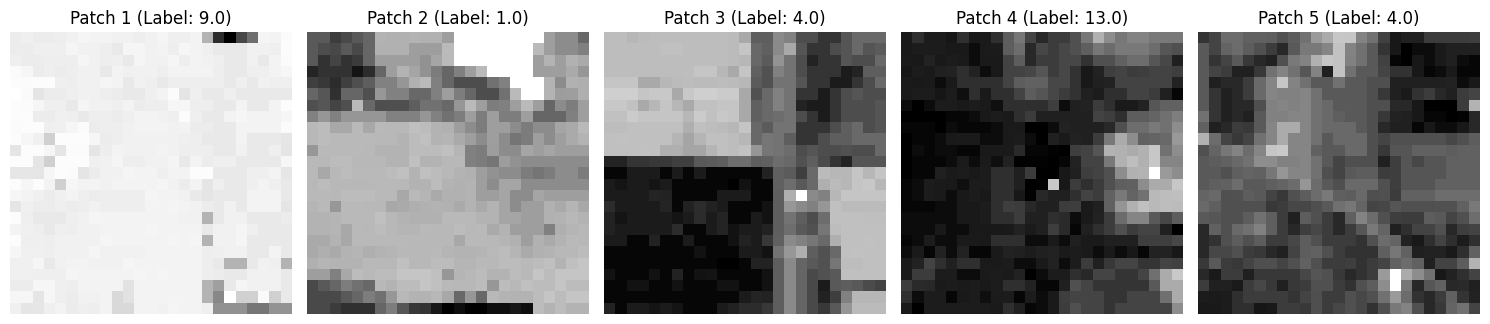

In [ ]:
 #prompt: write code to display few patches

# Assuming 'Xtrain' and 'ytrain' are defined from the previous code

import matplotlib.pyplot as plt
import numpy as np

# Number of patches to display
num_patches_to_display = 5

# Create a figure and axes
fig, axes = plt.subplots(1, num_patches_to_display, figsize=(15, 5))

# Iterate through the patches and display them
for i in range(num_patches_to_display):
  # Select a random patch index
  random_patch_index = np.random.randint(0, Xtrain.shape[0])

  # Get the patch and its corresponding label
  patch = Xtrain[random_patch_index]
  label = ytrain[random_patch_index]

  # Display the first band of the patch as grayscale
  # We select the first band using patch[:, :, 0]
  axes[i].imshow(patch[:, :, 0], cmap='gray')

  axes[i].set_title(f"Patch {i+1} (Label: {label})")
  axes[i].axis('off')

plt.tight_layout()
plt.show()

Label 0.0: 46 patches
Label 1.0: 1428 patches
Label 2.0: 830 patches
Label 3.0: 237 patches
Label 4.0: 483 patches
Label 5.0: 730 patches
Label 6.0: 28 patches
Label 7.0: 478 patches
Label 8.0: 20 patches
Label 9.0: 972 patches
Label 10.0: 2455 patches
Label 11.0: 593 patches
Label 12.0: 205 patches
Label 13.0: 1265 patches
Label 14.0: 386 patches
Label 15.0: 93 patches


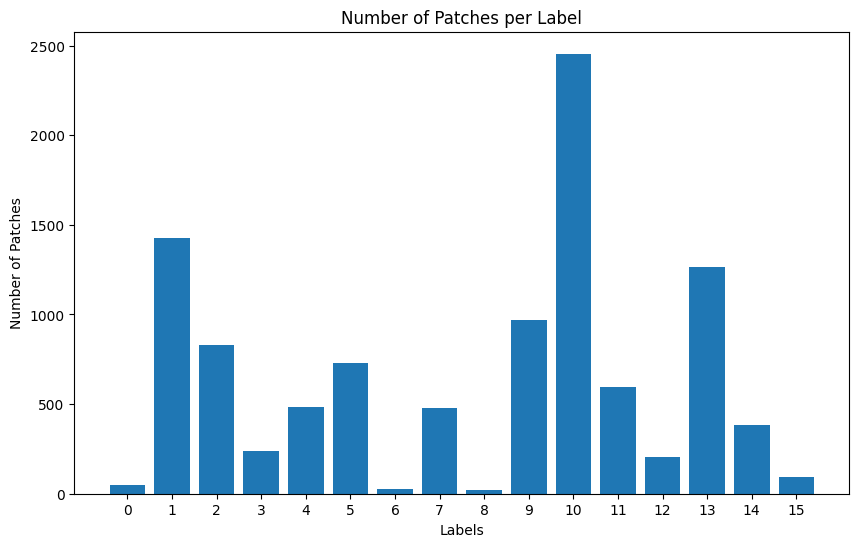

In [ ]:
# prompt: Write a code to show number of patches for each label

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'y' (labels) and 'GT' (ground truth) are defined in your code.
# Example: y = np.random.randint(0, 10, size=10000)  # Replace with your actual y
#          GT = np.random.randint(0, 10, size=(100, 100))  # Replace with your actual GT


# Count occurrences of each unique label in y
unique_labels, counts = np.unique(y, return_counts=True)

# Create a dictionary to store label counts
label_counts = dict(zip(unique_labels, counts))

# Print the number of patches for each label
for label, count in label_counts.items():
    print(f"Label {label}: {count} patches")

# Plot the label counts for better visualization
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Labels")
plt.ylabel("Number of Patches")
plt.title("Number of Patches per Label")
plt.xticks(list(label_counts.keys()))
plt.show()

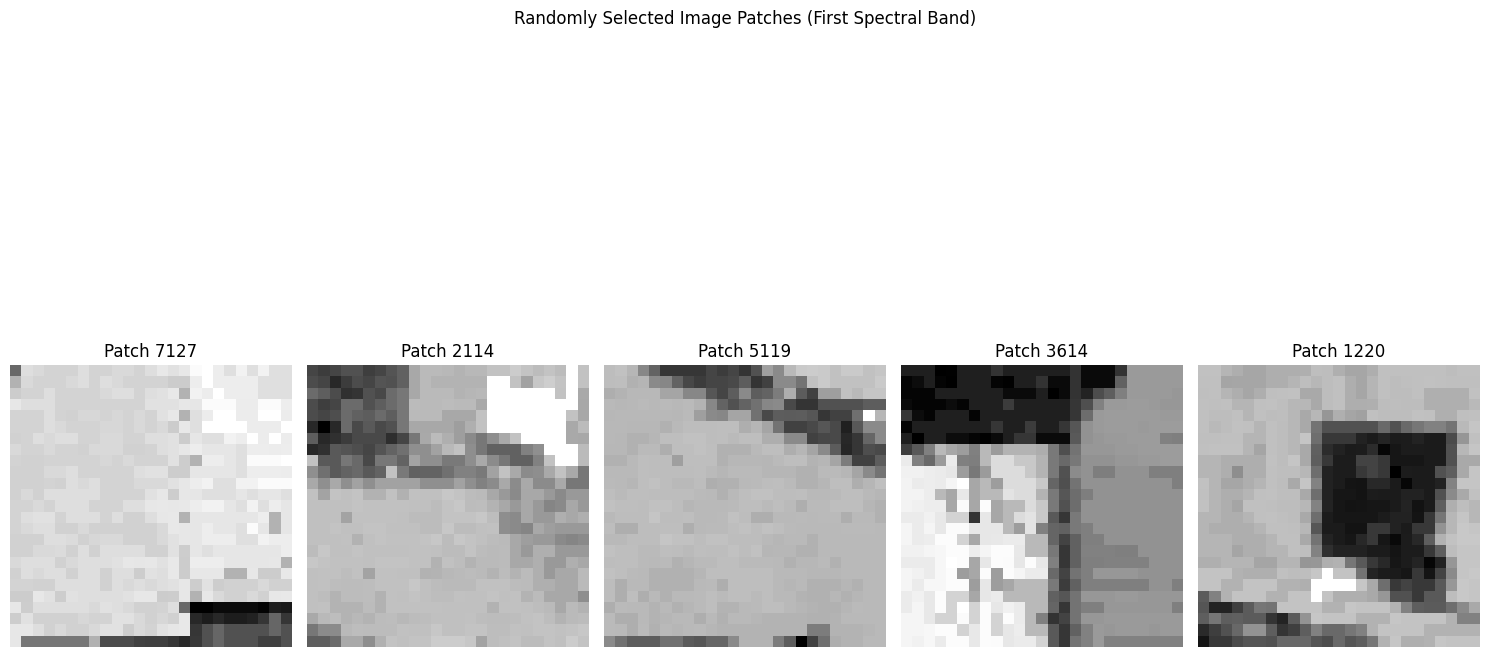

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X is defined and contains image patches
# Generate 5 random indices
random_indices = np.random.choice(range(X.shape[0]), size=5, replace=False)

# Plot the 5 random patches
plt.figure(figsize=(15, 10))
for i, patch_index in enumerate(random_indices):
    # Access the selected image patch
    image_patch = X[patch_index]

    # Create a subplot for each patch
    plt.subplot(1, 5, i + 1)
    plt.imshow(image_patch[:, :, 0], cmap='gray')  # Display the first spectral band
    plt.title(f"Patch {patch_index}")
    plt.axis('off')  # Hide axis for clarity

plt.suptitle("Randomly Selected Image Patches (First Spectral Band)")
plt.tight_layout()
plt.show()


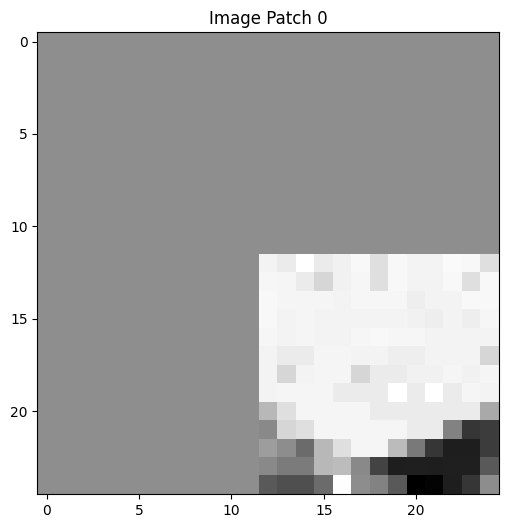

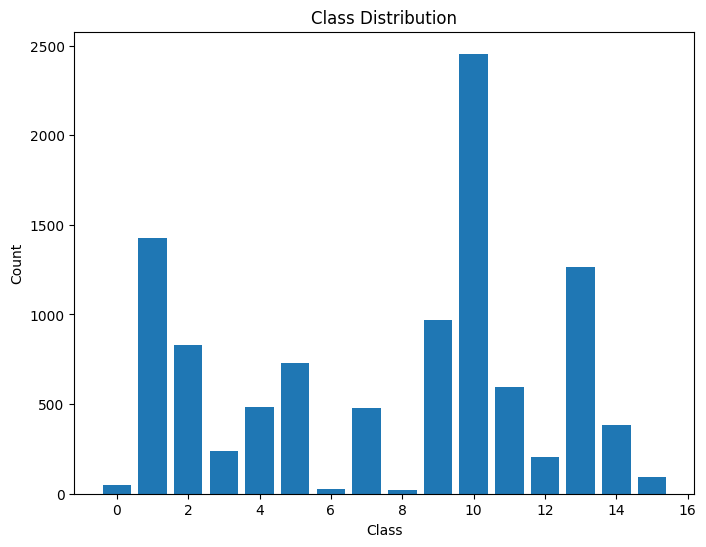

In [ ]:


import matplotlib.pyplot as plt

# Assuming X and y are defined as in your provided code
# Visualize X (assuming X is a 4D array of image patches)

# Choose an index for an image patch to visualize
patch_index = 0

# Access the selected image patch
image_patch = X[patch_index]

# Plot the image patch (assuming it represents spectral data)
plt.figure(figsize=(8, 6))
plt.imshow(image_patch[:, :, 0], cmap='gray')  # Display the first spectral band
plt.title(f"Image Patch {patch_index}")
plt.show()


# Visualize y (assuming y contains ground truth labels)
plt.figure(figsize=(8, 6))
plt.hist(y, bins=range(int(min(y)), int(max(y)) + 2), align='left', rwidth=0.8)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
class MambaModel(keras.Model):  # Inherit from keras.Model
    def __init__(self, modelargs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mamba_block = MambaBlock(modelargs)  # Use your MambaBlock
        self.flatten = layers.Flatten()  # Add layers as needed
        self.dense = layers.Dense(16, activation='softmax')  # Output layer for 16 classes


    def call(self, inputs):
        x = self.mamba_block(inputs)
        x = self.flatten(x)
        return self.dense(x)

In [ ]:
Xtrain_mamba.shape

(1024, 625, 15)

In [ ]:
start_time = time.process_time()

mamba_model = MambaModel(modelargs=args)

# Step 3: Compile the Model
mamba_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 4: Train the Model
# Fit the model to the training data
mamba_model.fit(Xtrain_mamba, ytrain1, epochs=30, batch_size=256, verbose=1)
training_time = time.process_time()-start_time

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 54s 12s/step - accuracy: 0.1969 - loss: 2.7588
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 48s 12s/step - accuracy: 0.4826 - loss: 2.6265
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - accuracy: 0.3479 - loss: 2.3819
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - accuracy: 0.2792 - loss: 2.1608
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - accuracy: 0.3164 - loss: 2.0511
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 12s/step - accuracy: 0.3849 - loss: 1.8926
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - accuracy: 0.4990 - loss: 1.7031
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - accuracy: 0.5776 - loss: 1.4867
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 12s/step - accuracy: 0.5665 - loss: 1.3327
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - accuracy: 0.6374 - loss: 1.0936
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - accuracy: 0.7115 - loss: 0.9112
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - accuracy: 0.7988 - loss: 0.7382
E

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = mamba_model.evaluate(Xtest_mamba, ytest1)

289/289 ━━━━━━━━━━━━━━━━━━━━ 151s 522ms/step - accuracy: 0.9106 - loss: 0.3209


In [ ]:

y_pred = mamba_model.predict(Xtest_mamba)


289/289 ━━━━━━━━━━━━━━━━━━━━ 148s 512ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1) # Get predicted class labels
y_true_classes = np.argmax(ytest1, axis=1)   # Get true class labels from one-hot encoded ytest

oa = metrics.accuracy_score(y_true_classes, y_pred_classes) # Compare class labels
kappa = metrics.cohen_kappa_score(y_true_classes, y_pred_classes)

print('MambaModel:', oa, kappa, ' Training Time:', training_time)
print('Test accuracy:', test_acc)


MambaModel: 0.9084010840108401 0.8948896533002609  Training Time: 2294.554727412
Test accuracy: 0.9084010720252991


##VISUALIZATION

/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


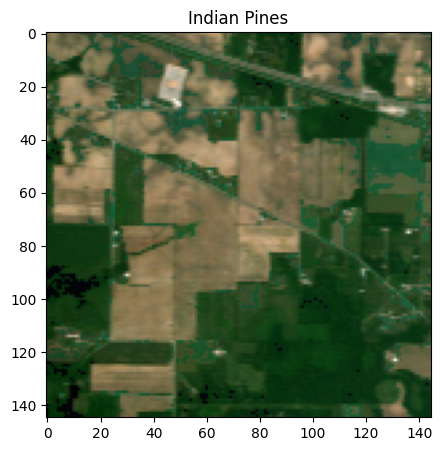

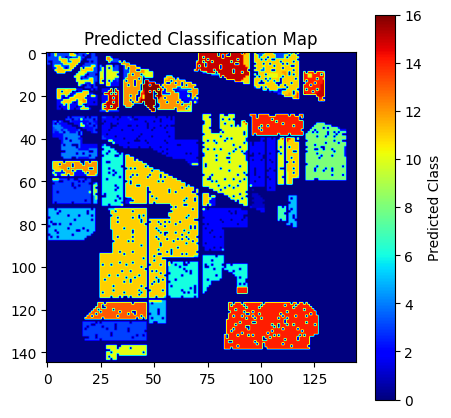

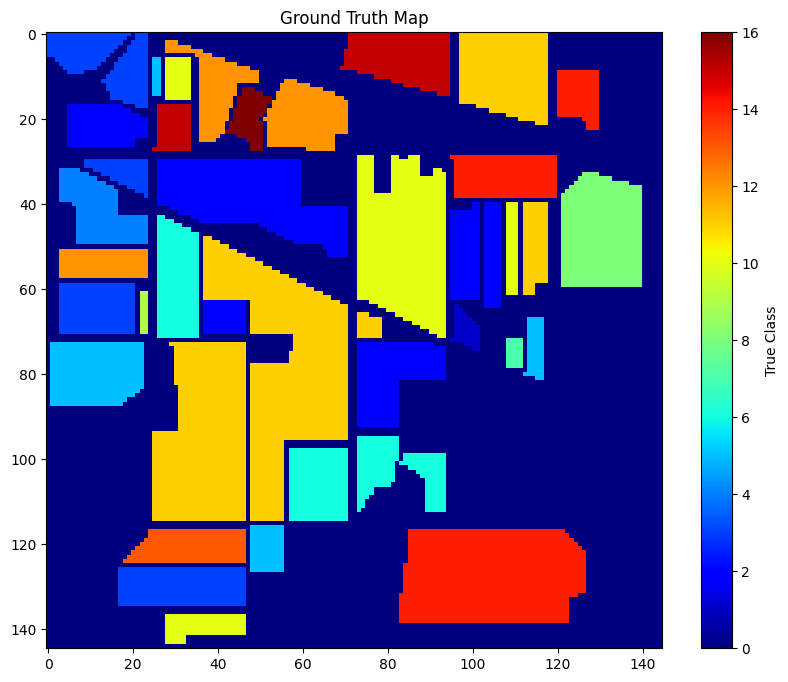

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# original images
view=spectral.imshow(HSI, (26, 14, 8), figsize=(5, 5), classes=GT, title='Indian Pines')

# Initialize an empty array for the predicted map with the same shape as GT
predicted_map = np.zeros_like(GT, dtype=int)

# Iterate through each test index and corresponding prediction
for idx, (row, col) in enumerate(test_indices):
    predicted_map[row, col] = y_pred_classes[idx] + 1  # Adjust classes if necessary

# Visualize the predicted classification map
plt.figure(figsize=(5, 5))
plt.imshow(predicted_map, cmap='jet')
plt.colorbar(label='Predicted Class')
plt.title('Predicted Classification Map')
plt.show()

# Visualize the ground truth map for comparison
plt.figure(figsize=(10, 8))
plt.imshow(GT, cmap='jet')
plt.colorbar(label='True Class')
plt.title('Ground Truth Map')
plt.show()
